# Import libraries

In [1]:
%pip install mat73
%pip install nibabel
%pip install hdf5storage

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import nibabel as nib
import torch
from torch import nn
import torchvision
from evaluate_KNN import *
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from os.path import join as opj
import pandas as pd
import nltk
from nltk.corpus import wordnet as wn
nltk.download('wordnet')
nltk.download('omw-1.4')

import tqdm
from torchsummary import summary
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
import shutil
from scipy.stats import hypergeom
import seaborn as sns
from termcolor import colored
from sklearn.neighbors import NearestNeighbors
from torchvision.utils import make_grid
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
import nibabel.processing
import pickle
from scipy.io import loadmat
import numpy as np
import pandas as pd
import sklearn.preprocessing
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier

from god_decoding_utils import *

from sklearn.metrics import classification_report

from torch import autocast
from diffusers import StableDiffusionPipeline
from diffusers import StableDiffusionImg2ImgPipeline

from PIL import Image
import ast
import matplotlib.pyplot as plt
import wandb
from PIL import ImageFilter

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MehrSystem\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\MehrSystem\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Data loading

In [3]:
# Initialize sub and roi variables
# You can change sub to each number in [1-5]
sub = "3"
roi = "ROI_VC"

# Initialize kamitani_data_mat with the path to a file containing data for Subject 3
kamitani_data_mat = f"data/fMRI/GOD/Subject{sub}.h5"

# Initialize imagenet_dir with the path to a directory containing images
imagenet_dir = "data/fMRI/imagenet/images"

# Initialize test_img_csv and train_img_csv with the paths to two CSV files
test_img_csv = 'data/fMRI/GOD/image_test_id.csv'
train_img_csv = 'data/fMRI/GOD/image_training_id.csv'
test_img_csv
train_img_csv
# Create a data_handler object using the specified arguments
handler = data_handler(h5_file=kamitani_data_mat, test_img_csv=test_img_csv, train_img_csv=train_img_csv)

# Get data using the get_data method of the handler object
Y, Y_test, Y_test_avg = handler.get_data(normalize=1, roi=roi)

# Get labels using the get_labels method of the handler object
labels_train, labels = handler.get_labels()

# Get filenames using the get_filenames method of the handler object
filenames_train, filenames_test = handler.get_filenames()

# Convert filenames_train and filenames_test from arrays to Python lists
filenames_train = [i.item() for i in filenames_train]
filenames_test = [i.item() for i in filenames_test]

# Initialize an empty list called filenames_test_avg
filenames_test_avg = []

# Iterate 50 times
for i in range(50):
    # Append the first element from filenames_test whose label is equal to i to filenames_test_avg
    filenames_test_avg.append(np.array(filenames_test)[labels==i][0])

In [4]:
# print the size of data
print("size of fmri data", len(Y))
# print the size of test data
print(len(Y_test_avg))

size of fmri data 1200
50


In [5]:
# print the labels
print(labels[:10])

[ 1 34 37 15 38  4 39 36 44  2]


# Wordnet mapping

In [6]:
with open('class_to_wordnet.json',) as f:
    data = f.read()

class2wordnet = ast.literal_eval(data)
wordnet2class= {v["id"] : k for k,v in class2wordnet.items()}

In [7]:
wordnet2class.values()

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

In [8]:
# Initialize img_dir_path with the path to a directory containing training images
img_dir_path = "data/fMRI/imagenet/images/training"

# Initialize image_paths with a list of file paths to the training images
image_paths = [os.path.join(img_dir_path, i) for i in filenames_train]

# Initialize test_image_paths with a list of file paths to the test images
test_image_paths = [os.path.join(imagenet_dir,"test", i) for i in filenames_test_avg]

# Split the data into train and validation sets using the train_test_split function
fmri_train, fmri_val, image_train, image_val = train_test_split(Y, image_paths, test_size=0.1, random_state=42)


In [9]:
# print the number of features
print("fmri_train size = ", fmri_train.size)
print("fmri_val size = ", fmri_train.size)

fmri_train size =  5014440
fmri_val size =  5014440


(500, 500, 3)


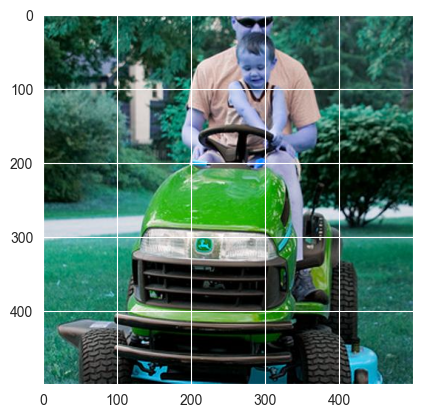

(500, 500, 3)


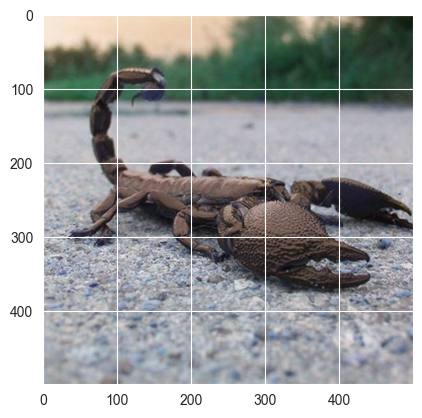

(500, 500, 3)


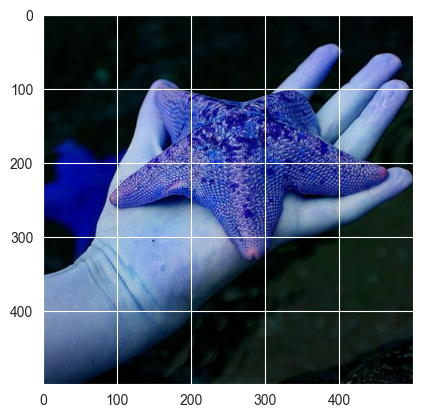

(500, 500, 3)


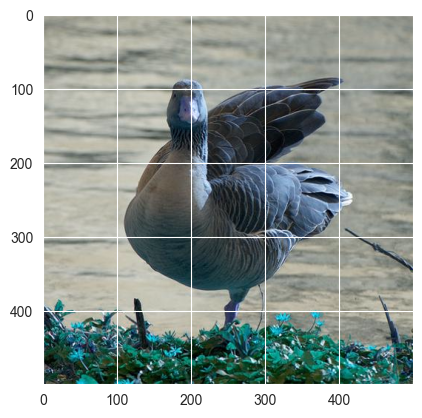

(500, 500, 3)


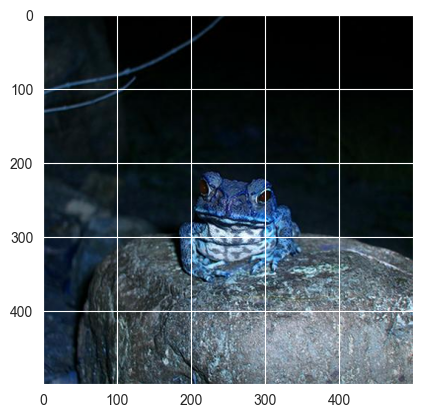

In [10]:
# plot some random images from train images
for j in range(5):
    # Select a random train sample
    i = np.random.randint(0, len(image_train))

    # Plot the selected train sample
    img = cv2.imread(image_train[i])
    plt.imshow(img)
    print(img.shape)
    plt.show()

# Dataset and Dataloaders

In [11]:
# Initialize BS with the batch size
BS = 64

# Initialize normalize with a transformation that normalizes the data
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Initialize transform with a transformation that resizes and converts images to tensors
transform = torchvision.transforms.Compose([torchvision.transforms.Resize(224),
                                            torchvision.transforms.ToTensor(),
                                            normalize])

# Initialize train_dataset with a CustomDataset object using the fmri_train and image_train data and the transform
train_dataset = CustomDataset(fmri_train, image_train, transform)

# Initialize val_dataset with a CustomDataset object using the fmri_val and image_val data and the transform
val_dataset = CustomDataset(fmri_val, image_val, transform)

# Initialize test_dataset with a CustomDataset object using the Y_test_avg and test_image_paths data and the transform
test_dataset = CustomDataset(Y_test_avg, test_image_paths, transform)

# Initialize train_dataloader with a DataLoader object using the train_dataset and the specified batch size
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BS, shuffle=False)

# Initialize val_dataloader with a DataLoader object using the val_dataset and the specified batch size
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BS, shuffle=False)

# Initialize test_dataloader with a DataLoader object using the test_dataset and the specified batch size
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BS, shuffle=False)

# CNN Model

In [12]:
# Load a pre-trained ResNet50 model from the torchvision library
model = torchvision.models.resnet50(pretrained=True)
# Get the list of child modules of the model
modules = list(model.children())

# Remove the last element of the list of child modules
modules = modules[:-1]

# Create a new Sequential model using the remaining child modules
model = nn.Sequential(*modules)

C:\Users\MehrSystem\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\MehrSystem\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
# print the model
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


### Extract the latent representation for each image and store it

In [14]:
# Initialize empty lists to store the data
x_train = []
z_train = []
y_train = []

x_val = []
z_val = []
y_val = []

x_test = []
z_test = []
y_test = []

# Iterate over the train_dataloader, val_dataloader, and test_dataloader
# x are fMRI preprocessed data, y are the image stimuli

with torch.no_grad():
    for x, y in tqdm.tqdm(train_dataloader):
        # Use the model to compute the latent representation of y
        z = model(y)
        # Append the data to the respective lists
        x_train.append(x)
        z_train.append(z.squeeze())
        y_train.append(y)

    for x, y in tqdm.tqdm(val_dataloader):
        # Use the model to compute the latent representation of y
        z = model(y)
        # Append the data to the respective lists
        x_val.append(x)
        z_val.append(z.squeeze())
        y_val.append(y)
    for x, y in tqdm.tqdm(test_dataloader):
        # Use the model to compute the latent representation of y
        z = model(y)
        # Append the data to the respective lists
        x_test.append(x)
        z_test.append(z.squeeze())
        y_test.append(y)

# Concatenate the lists of data into numpy arrays
x_train = torch.cat(x_train, 0).numpy()
z_train = torch.cat(z_train, 0).numpy()
y_train = torch.cat(y_train, 0).numpy()

x_val = torch.cat(x_val, 0).numpy()
z_val = torch.cat(z_val, 0).numpy()
y_val = torch.cat(y_val, 0).numpy()

x_test = torch.cat(x_test, 0).numpy()
z_test = torch.cat(z_test, 0).numpy()
y_test = torch.cat(y_test, 0).numpy()


100%|██████████| 1/1 [00:03<00:00,  3.98s/it]


In [15]:
print(z_train.shape)
print(z_test.shape)
print(z_val.shape)

(1080, 2048)
(50, 2048)
(120, 2048)


# Linear Model

In [16]:
from sklearn.model_selection import GridSearchCV

ridge=Ridge(max_iter=5000)
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,10,100,1000,10000,]}
ridge_regressor=GridSearchCV(ridge,parameters,scoring='neg_mean_squared_error',cv=5)
ridge_regressor.fit(x_train,z_train)

print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

C:\Users\MehrSystem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\MehrSystem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\MehrSystem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\MehrSystem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=7.74628e-20): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
C:\Users\MehrSystem\AppData\Local\Programs\Python\Python310\li

{'alpha': 10000}
-0.18195555745550646


In [17]:
ridge = Ridge(alpha=1000, max_iter=5000)

ridge.fit(x_train, z_train)

Ridge(alpha=1000, max_iter=5000)

In [18]:
# Use the model to predict the latent representation of the test data
pred_test_latent = ridge.predict(x_test)

# Initialize epsilon with a small value
epsilon = 1e-10

# Standardize the predicted latent representation of the test data
std_norm_test_latent = (pred_test_latent - np.mean(pred_test_latent, axis=0)) / (epsilon + np.std(pred_test_latent, axis=0))

# Scale and shift the standardized predicted latent representation to match the scale and shift of the training data
pred_instance = std_norm_test_latent * np.std(z_train, axis=0) + np.mean(z_train, axis=0)

# Use the model to predict the latent representation of the training and validation data
train_predicted = ridge.predict(x_train)
val_predicted = ridge.predict(x_val)

# Calculate the root mean squared error (RMSE) of the predictions
print("rmse", mean_squared_error(z_train, train_predicted))
print("rmse", mean_squared_error(z_val, val_predicted))
print("rmse", mean_squared_error(z_test, pred_instance))
print("rmse", mean_squared_error(z_test, pred_test_latent))


rmse 0.03112794856925971
rmse 0.20582907075477286
rmse 0.2667757419987978
rmse 0.16935964149718472


# Perceptron

In [19]:
fmri_dim=x_train.shape[-1]
latent_dim=z_train.shape[-1]

In [20]:
def get_activation(activation):
    if activation=="relu":
        return nn.ReLU()

    elif activation=="gelu":
        return nn.GELU()

    elif activation=="tanh":
        return nn.Tanh()

    elif activation=="sigmoid":
        return nn.Sigmoid()

    elif activation=="selu":
        return nn.SELU()

In [21]:
class BrainMLP(nn.Module):
    def __init__(self,latent_dim,hidden=[128],dropout=0.2,activation="gelu"):
        super().__init__()


        self.model=[]
        for h in hidden:
            self.model.append(nn.LazyLinear(h))
            self.model.append(get_activation(activation))

        self.model.append(nn.Dropout(dropout))
        self.model.append(nn.LazyLinear(latent_dim))

        self.model=nn.Sequential(*self.model)

    def forward(self,x):
        return self.model(x)

In [22]:
# Initialize a BrainMLP model with specified latent dimension, hidden layer sizes, dropout rate, and activation function
brain_model = BrainMLP(latent_dim=latent_dim, hidden=[1024], dropout=0.3, activation="tanh")

# Print a summary of the model, including the input and output shapes and the number of parameters
summary(brain_model, (fmri_dim,), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]       4,755,456
              Tanh-2                 [-1, 1024]               0
           Dropout-3                 [-1, 1024]               0
            Linear-4                 [-1, 2048]       2,099,200
Total params: 6,854,656
Trainable params: 6,854,656
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.04
Params size (MB): 26.15
Estimated Total Size (MB): 26.21
----------------------------------------------------------------


C:\Users\MehrSystem\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [23]:
# Convert the x_train, z_train, x_val, z_val, x_test, and z_test arrays to PyTorch tensors
train_brain_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(z_train))
val_brain_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_val), torch.Tensor(z_val))
test_brain_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_test), torch.Tensor(z_test))

# Create DataLoaders for the training, validation, and test sets
train_brain_dataloader = torch.utils.data.DataLoader(train_brain_dataset, batch_size=64, shuffle=True)
val_brain_dataloader = torch.utils.data.DataLoader(val_brain_dataset, batch_size=64, shuffle=True)
test_brain_dataloader = torch.utils.data.DataLoader(test_brain_dataset, batch_size=64, shuffle=True)

In [24]:
# Set the device to use for training
device = "cpu"
import torch

print("Torch version:",torch.__version__)

print("Is CUDA enabled?",torch.cuda.is_available())
# Set the number of epochs to train for
EPOCHS = 200

# Set the step size and gamma for the learning rate scheduler
scheduler_step = 60
gamma = 0.5

# Move the brain model to the designated device
brain_model = brain_model.to(device)

# Create an Adam optimizer with a weight decay of 1e-5
optim = torch.optim.Adam(brain_model.parameters(), lr=3e-3, weight_decay=1e-5)

# Create a learning rate scheduler that reduces the learning rate by a factor of gamma every scheduler_step epochs
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=scheduler_step, gamma=gamma)

# Create a mean squared error loss function
criterion = nn.MSELoss()

#Uncomment the following line to use a cosine embedding loss instead
# criterion = nn.CosineEmbeddingLoss()
# model=model.to(device)

Torch version: 2.0.1+cpu
Is CUDA enabled? False


In [25]:
def train_brain_epoch(model, train_dataloader, criterion=None, optim=None, device="cpu"):
    """
    Trains the model for one epoch using the specified dataloader and optimizer.

    Parameters:
    - model: PyTorch model to be trained
    - train_dataloader: Dataloader for the training data
    - criterion: Loss function to be used for training
    - optim: Optimizer to be used for training
    - device: Device to run the model and data on (CPU or GPU)

    Returns:
    - mean_loss: Mean loss of the model over the training data
    """
    model.train()

    loss_tmp = []
    # Iterate over the training data
    for x, y in train_dataloader:
        # Zero the gradients of the optimizer
        optim.zero_grad()
        # Move the data to the specified device
        x, y = x.to(device), y.to(device)
        # Get the model's prediction for the input data
        y_pred = model(x)

        # Calculate the loss based on the criterion and model's prediction
        if isinstance(criterion, nn.CosineEmbeddingLoss):
            # Set the target to 1 if using the CosineEmbeddingL
            target=torch.ones(y_pred.shape[0]).to(device)

            loss=criterion(y_pred.squeeze(),y.squeeze(),target)

        else:

            loss=criterion(y_pred.squeeze(),y.squeeze())
        # Backpropagate the loss and update the model's parameters
        loss.backward()
        optim.step()
        # Add the loss to the list of losses
        loss_tmp.append(loss.item())
    # Calculate the mean loss over all the data
    mean_loss = np.mean(loss_tmp)
    return mean_loss


In [26]:
loss_history=[]
val_loss_history=[]

# frequency of validation
val_freq=1

train = True
# if train is set to True, train the model
if train:
    # create a progress bar
    pbar=tqdm.tqdm(range(EPOCHS))
    # iterate over the number of epochs
    for epoch in pbar:
        # call the train_brain_epoch function to train the model for one epoch
        loss=train_brain_epoch(brain_model,train_dataloader=train_brain_dataloader,criterion=criterion,optim=optim,device=device)

        # step the scheduler to adjust the learning rate
        scheduler.step()

        # append the loss to the loss history
        loss_history.append(loss)

        # if the current epoch is a multiple of val_freq, call the val_brain_epoch function to get the validation loss
        if epoch%val_freq==0:
            val_loss=val_brain_epoch(brain_model,val_dataloader=val_brain_dataloader,criterion=criterion,optim=optim,device=device)
            val_loss_history.append(val_loss)

        # update the progress bar description with the current epoch and loss information
        if epoch>val_freq:
            pbar.set_description(f"[INFO] epoch: {epoch} loss: {loss_history[-1]} val_loss: {val_loss_history[-1]}")
        else:
            pbar.set_description(f"[INFO] epoch: {epoch} loss: {loss_history[-1]}")


    #save final weights
    torch.save(brain_model.state_dict(),f"models/brain_model_weights_sub{sub}.pt")

else:
    #load pretrained models

    brain_model.load_state_dict(torch.load(f"models/brain_model_weights_sub{sub}.pt"))
    brain_model=brain_model.to(device)
    ridge = pickle.load(open(f"models/ridge_sub{sub}.sav", 'rb'))

[INFO] epoch: 199 loss: 0.04319722358794773 val_loss: 0.21960272639989853: 100%|██████████| 200/200 [03:46<00:00,  1.13s/it] 


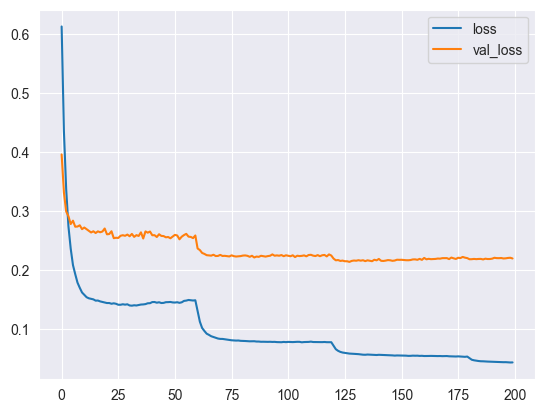

In [27]:
import matplotlib.pyplot as plt
if train:
    plt.plot(loss_history,label="loss")
    plt.plot(val_loss_history,label="val_loss")
    plt.legend()

In [28]:
# Initialize variables for predictions on train, val, and test sets
train_predict = None
val_predict = None
test_predict = None

# Turn off gradient calculation
with torch.no_grad():
  # Make predictions on train set
  train_predict = brain_model(torch.Tensor(x_train).to(device)).cpu().numpy()
  # Make predictions on val set
  val_predict = brain_model(torch.Tensor(x_val).to(device)).cpu().numpy()
  # Make predictions on test set
  test_predict = brain_model(torch.Tensor(x_test).to(device)).cpu().numpy()

  # Standardize test predictions
  std_norm_test_latent = (test_predict - np.mean(test_predict, axis=0)) / np.std(test_predict, axis=0)
  # Adjust test predictions using mean and std of training set
  test_predicted_adjusted = std_norm_test_latent * np.std(z_train, axis=0) + np.mean(z_train, axis=0)

# Calculate and print root mean squared error for train, val, and test sets
print("rmse", mean_squared_error(z_train, train_predict))
print("rmse", mean_squared_error(z_val, val_predict))
print("rmse", mean_squared_error(z_test, test_predicted_adjusted))
print("rmse", mean_squared_error(z_test, test_predict))

rmse 0.019056655
rmse 0.21962756
rmse 0.2647794
rmse 0.1764743


# classification

Following cells use nearest neighbors in the latent space to provide candidate labels for classification.

In [29]:
#transform to restore original image means and stds
unnorm = torchvision.transforms.Compose([ torchvision.transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), torchvision.transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1.,1.,1.] )])

In [30]:
#where image features are saved
features_path="data/fMRI/imagenet/features/feature_imagenet_500_resnet50.pt"
labels_path="data/fMRI/imagenet/features/labels_imagenet_500_resnet50.pt"

#load image features
features=torch.load(features_path)
labels=torch.load(labels_path)

In [31]:
# Load labels for classifying the images
with open('classes.txt', 'rb') as handle:
    data_dict = handle.read()
idx2name = pickle.loads(data_dict)


In [32]:
#print(data_dict)
print(idx2name)

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculatum', 29: 'axolotl, mu

In [33]:
# Load a pre-trained ResNet50 model and use the last fully-connected layer as the classifier head (should be the head of the CNN used before!)
clf = torchvision.models.resnet50(pretrained=True)
modules = list(clf.children())[-1:]
clf = nn.Sequential(*modules)

# Load the Nearest Neighbors model and fit it to the features of the images
nbrs = NearestNeighbors(n_neighbors=5).fit(features.numpy())

C:\Users\MehrSystem\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\MehrSystem\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
# Initialize lists to store the predictions made by each model on the test data
z_test_brain = []
z_test_ridge = []
z_test_model = []
images_test = []

# Disable gradient calculation
with torch.no_grad():
    # Iterate over the test data using a progress bar
    for x, y in tqdm.tqdm(test_dataloader):
        # Make predictions using the brain_model
        z_b = brain_model(x.float().to(device)).cpu()
        # Make predictions using the model
        z_m = model(y).cpu().squeeze()
        # Make predictions using the ridge model
        z_r = torch.Tensor(ridge.predict(x.numpy()))

        # Append the predictions to the appropriate lists
        z_test_brain.append(z_b)
        z_test_model.append(z_m)
        z_test_ridge.append(z_r)
        images_test.append(y)

# Concatenate the lists of predictions into tensors
z_test_brain = torch.cat(z_test_brain, 0)
z_test_model = torch.cat(z_test_model, 0)
z_test_ridge = torch.cat(z_test_ridge, 0)
# Concatenate the list of input data into a tensor
images_test = torch.cat(images_test, 0)

100%|██████████| 1/1 [00:04<00:00,  4.24s/it]


In [35]:
# Standardize the test brain predictions using the mean and standard deviation of the training data
z_test_brain_std_norm = (z_test_brain - z_test_brain.mean(dim=0)) / z_test_brain.std(dim=0)
# Adjust the standardized test brain predictions using the mean and standard deviation of the training data
z_test_brain_adj = z_test_brain_std_norm * np.std(z_train, axis=0) + np.mean(z_train, axis=0)

# Standardize the test ridge predictions using the mean and standard deviation of the training data
z_test_ridge_std_norm = (z_test_ridge - z_test_ridge.mean(dim=0)) / z_test_ridge.std(dim=0)
# Adjust the standardized test ridge predictions using the mean and standard deviation of the training data
z_test_ridge_adj = z_test_ridge_std_norm * np.std(z_train, axis=0) + np.mean(z_train, axis=0)

# Use the clf model to classify the test brain, model, and ridge predictions
out_test_brain = clf(z_test_brain_adj)
out_test_model = clf(z_test_model)
out_test_ridge = clf(z_test_ridge_adj)

Text(0.5, 1.0, 'model: grand piano, grand')

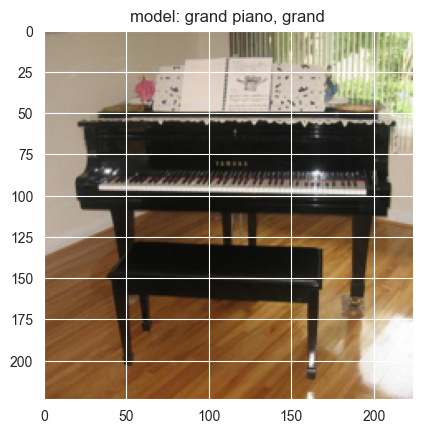

In [36]:
# Select a random test sample
i = np.random.randint(0, 50)

# Plot the selected test sample
plt.imshow(unnorm(images_test[i]).permute(1, 2, 0))
plt.title(f"model: {idx2name[out_test_model[i].argmax().item()]}")

In [37]:
# Use the nearest neighbors model to find the nearest neighbors of the test brain, model, and ridge predictions
nn_brain = nbrs.kneighbors(z_test_brain_adj[i].numpy().reshape(1, -1))
nn_model = nbrs.kneighbors(z_test_model[i].numpy().reshape(1, -1))
nn_ridge = nbrs.kneighbors(z_test_ridge_adj[i].numpy().reshape(1, -1))
print("nn_brain", nn_brain)
print("nn_model", nn_model)
print("ridge", nn_ridge)

nn_brain (array([[16.32123621, 16.41350193, 16.89294745, 17.09608591, 17.13556251]]), array([[334426,  31231, 270505,  12152, 322254]], dtype=int64))
nn_model (array([[11.739559  , 11.81280097, 12.23742778, 12.84243003, 12.99639197]]), array([[402176,  16259, 290436, 326385, 420370]], dtype=int64))
ridge (array([[16.33409729, 16.38749765, 17.11194687, 17.18876505, 17.20652002]]), array([[334426,  31231, 270505,  15966,  12152]], dtype=int64))


In [38]:
# Get the classifications of the nearest neighbors for the test brain, model, and ridge predictions
nn_model_guess = [idx2name[i.item()] for i in labels[nn_model[1][0]]]
nn_brain_guess = [idx2name[i.item()] for i in labels[nn_brain[1][0]]]
nn_ridge_guess = [idx2name[i.item()] for i in labels[nn_ridge[1][0]]]

# Print the nearest neighbor classification for the test brain, model, and ridge predictions
print(f"NN [MODEL] closest: {nn_model_guess[0]}")
print(f"NN [BRAIN] closest: {nn_brain_guess[0]}")
print(f"NN [RIDGE] closest: {nn_ridge_guess[0]}")
print()

# Print the other nearest neighbor classifications for the test brain, model, and ridge predictions
print(f"NN [MODEL] other guess: {' '.join(nn_model_guess)}")
print(f"NN [BRAIN] other guess: {' '.join(nn_brain_guess)}")
print(f"NN [RIDGE] other guess: {' '.join(nn_ridge_guess)}")

NN [MODEL] closest: grand piano, grand
NN [BRAIN] closest: refrigerator, icebox
NN [RIDGE] closest: refrigerator, icebox

NN [MODEL] other guess: grand piano, grand grand piano, grand grand piano, grand grand piano, grand upright, upright piano
NN [BRAIN] other guess: refrigerator, icebox refrigerator, icebox file, file cabinet, filing cabinet refrigerator, icebox sliding door
NN [RIDGE] other guess: refrigerator, icebox refrigerator, icebox file, file cabinet, filing cabinet screen, CRT screen refrigerator, icebox


In [39]:
# Print the classifications made by the clf model for the test brain, model, and ridge predictions
print(f"clf brain: {idx2name[out_test_brain[i].argmax().item()]}")
print(f"clf ridge: {idx2name[out_test_ridge[i].argmax().item()]}")
print()

clf brain: printer
clf ridge: printer



 # 5.Evaluation

In [40]:
#transform to restore original image means and stds
unnorm = torchvision.transforms.Compose([ torchvision.transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), torchvision.transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1.,1.,1.] )])

#where image features are saved
features_path="data/fMRI/imagenet/features/feature_imagenet_500_resnet50.pt"
labels_path="data/fMRI/imagenet/features/labels_imagenet_500_resnet50.pt"

#load image features
features=torch.load(features_path)
labels=torch.load(labels_path)

In [41]:
# Load labels for classifying the images
with open('classes.txt', 'rb') as handle:
    data_dict = handle.read()
idx2name = pickle.loads(data_dict)

# Load a pre-trained ResNet50 model and use the last fully-connected layer as the classifier head (should be the head of the CNN used before!)
clf = torchvision.models.resnet50(pretrained=True)
modules = list(clf.children())[-1:]
clf = nn.Sequential(*modules)

# Load the Nearest Neighbors model and fit it to the features of the images
nbrs = NearestNeighbors(n_neighbors=5).fit(features.numpy())

C:\Users\MehrSystem\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\MehrSystem\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [42]:
# Use the clf model to classify the latent values predicted by the ridge model on fMRI data (brain) and the latent values predicted by the resnet model on image data (model)

with torch.no_grad():
    clf_brain_train = clf(torch.Tensor(train_predicted))
    clf_model_train = clf(torch.Tensor(z_train))
    clf_brain_val = clf(torch.Tensor(val_predicted))
    clf_model_val = clf(torch.Tensor(z_val))
    clf_brain_test = clf(torch.Tensor(test_predict))
    clf_model_test = clf(torch.Tensor(z_test))
    clf_brain_test_adj = clf(torch.Tensor(test_predicted_adjusted))
    clf_model_test_adj = clf(torch.Tensor(z_test))

# Predictions from Nearest Neighbors

In [43]:
# Use the nearest neighbors model to find the nearest neighbors of the latent values predicted by the ridge model on fMRI data (brain) and the latent values predicted by the resnet model on image data (model)

nbrs_brain_train = nbrs.kneighbors(train_predicted)
nbrs_model_train = nbrs.kneighbors(z_train)

In [44]:
# Use the nearest neighbors model to find the nearest neighbors of the latent values predicted by the ridge model on fMRI data (brain) and the latent values predicted by the resnet model on image data (model)

nbrs_brain_val = nbrs.kneighbors(val_predicted)
nbrs_model_val = nbrs.kneighbors(z_val)
nbrs_brain_test = nbrs.kneighbors(test_predict)
nbrs_model_test = nbrs.kneighbors(z_test)
nbrs_brain_test_adj = nbrs.kneighbors(test_predicted_adjusted)
nbrs_model_test_adj = nbrs_model_test

In [45]:
# Get the labels for the nearest neighbors of the latent values predicted by the ridge model on fMRI data (brain) and the latent values predicted by the resnet model on image data (model)
nbrs_brain_train = labels[nbrs_brain_train[1]]
print(nbrs_model_train)
nbrs_model_train = labels[nbrs_model_train[1]]
nbrs_brain_val = labels[nbrs_brain_val[1]]
nbrs_model_val = labels[nbrs_model_val[1]]
nbrs_brain_test = labels[nbrs_brain_test[1]]
nbrs_model_test = labels[nbrs_model_test[1]]
nbrs_brain_test_adj = labels[nbrs_brain_test_adj[1]]
nbrs_model_test_adj = nbrs_model_test

(array([[ 6.50468159,  6.75188363, 13.16210227, 14.227006  , 14.36484228],
       [11.84630772, 12.40342146, 12.70628012, 13.07243823, 13.56772102],
       [14.81005221, 16.56029798, 18.25334994, 18.33489808, 18.76651616],
       ...,
       [13.42056186, 14.01347847, 14.44624995, 14.65187251, 15.02887947],
       [15.82193327, 15.91327193, 16.00281023, 16.29154938, 16.3338815 ],
       [16.77820092, 16.92497934, 17.01960611, 17.21500994, 17.23765941]]), array([[260451, 125199, 317746, 341915, 138624],
       [  6074, 113370,  90112,  21331, 424305],
       [149765,  10186, 253833,  32918,  95839],
       ...,
       [141979, 403890, 302492, 209254, 183284],
       [157546, 155253, 447204, 129562, 271178],
       [  5426, 238422, 369658, 232169, 190481]], dtype=int64))


# Evaluation

### Check if the best prediction from brain model is in the 5 most probable predcitions from image model.

In [46]:
acc_clf_train_top=top_5_acc(clf_brain_train,clf_model_train)
acc_clf_val_top=top_5_acc(clf_brain_val,clf_model_val)
acc_clf_test_top=top_5_acc(clf_brain_test_adj,clf_model_test)


acc_nbrs_train_top=top_5_nbrs_acc(nbrs_brain_train,nbrs_model_train)
acc_nbrs_val_top=top_5_nbrs_acc(nbrs_brain_val,nbrs_model_val)
acc_nbrs_test_top=top_5_nbrs_acc(nbrs_brain_test_adj,nbrs_model_test)


print(f"[TOP 1] Resnet Head Classifier, Train acc: {acc_clf_train_top} Val acc: {acc_clf_val_top} Test acc: {acc_clf_test_top}")
print(f"[TOP 1] Neighbors Classifier, Train acc: {acc_nbrs_train_top} Val acc: {acc_nbrs_val_top} Test acc: {acc_nbrs_test_top}")

tensor([[334, 334, 334, 334, 334],
        [ 77,  77,  77,  77,  77],
        [447, 447, 759, 581, 447],
        ...,
        [446, 446, 446, 446, 446],
        [ 99,  99,  99,  99,  99],
        [570, 424, 570, 521, 622]])
tensor([[334, 334, 334, 334, 334],
        [ 77,  77,  77,  77,  77],
        [447, 447, 759, 581, 447],
        ...,
        [446, 446, 446, 446, 446],
        [ 99,  99,  99,  99,  99],
        [570, 424, 570, 521, 622]])
tensor([[334, 334, 334, 334, 334],
        [ 77,  77,  77,  77,  77],
        [447, 447, 759, 581, 447],
        ...,
        [446, 446, 446, 446, 446],
        [ 99,  99,  99,  99,  99],
        [570, 424, 570, 521, 622]])
tensor([[334, 334, 334, 334, 334],
        [ 77,  77,  77,  77,  77],
        [447, 447, 759, 581, 447],
        ...,
        [446, 446, 446, 446, 446],
        [ 99,  99,  99,  99,  99],
        [570, 424, 570, 521, 622]])
tensor([[334, 334, 334, 334, 334],
        [ 77,  77,  77,  77,  77],
        [447, 447, 759, 581, 447],

### Overlap between top-5 from brain model predictions and CNN predictions

In [47]:
acc_clf_train=evaluate_topk(clf_brain_train,clf_model_train)
acc_clf_val=evaluate_topk(clf_brain_val,clf_model_val)
acc_clf_test=evaluate_topk(clf_brain_test_adj,clf_model_test)

acc_nbrs_train=evaluate_topk_nbrs(nbrs_brain_train,nbrs_model_train)
acc_nbrs_val=evaluate_topk_nbrs(nbrs_brain_val,nbrs_model_val)
acc_nbrs_test=evaluate_topk_nbrs(nbrs_brain_test_adj,nbrs_model_test)

print(f"[TOP 5] Resnet Head Classifier, \n Train acc: {acc_clf_train} \n Val acc: {acc_clf_val} \nTest acc: {acc_clf_test} \n")
print(f"[TOP 5] Neighbors Classifier, \n Train acc: {acc_nbrs_train} \n Val acc: {acc_nbrs_val} \n Test acc: {acc_nbrs_test}")


[TOP 5] Resnet Head Classifier, 
 Train acc: {0: 0.0, 1: 0.000925925925925926, 2: 0.023148148148148147, 3: 0.1287037037037037, 4: 0.47685185185185186, 5: 0.37037037037037035} 
 Val acc: {0: 0.7666666666666667, 1: 0.19166666666666668, 2: 0.03333333333333333, 3: 0.008333333333333333, 4: 0.0, 5: 0.0} 
Test acc: {0: 0.74, 1: 0.12, 2: 0.04, 3: 0.1, 4: 0.0, 5: 0.0} 

[TOP 5] Neighbors Classifier, 
 Train acc: {0: 0.5657407407407408, 1: 0.18611111111111112, 2: 0.13518518518518519, 3: 0.07407407407407407, 4: 0.025925925925925925, 5: 0.012962962962962963} 
 Val acc: {0: 0.9416666666666667, 1: 0.05, 2: 0.008333333333333333, 3: 0.0, 4: 0.0, 5: 0.0} 
 Test acc: {0: 0.96, 1: 0.04, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0}


Text(0.5, 0, '# of matching between top5')

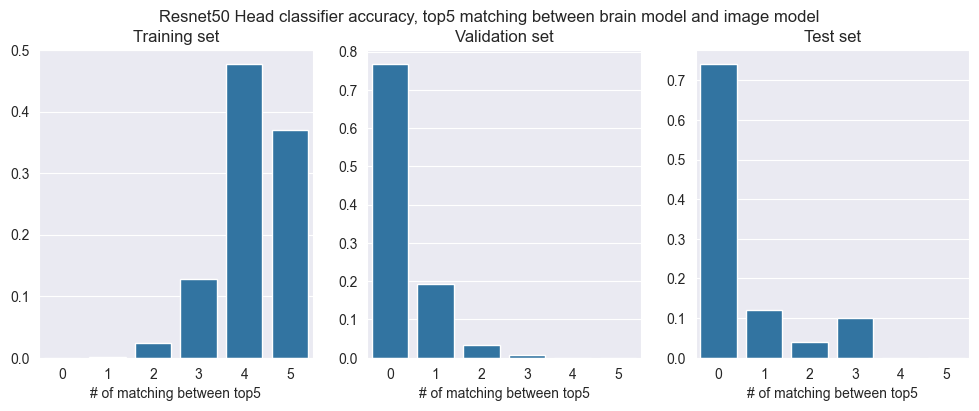

In [48]:
fig,axs=plt.subplots(1,3,figsize=(12,4))

fig.suptitle("Resnet50 Head classifier accuracy, top5 matching between brain model and image model")

sns.barplot(x=list(acc_clf_train.keys()),y=list(acc_clf_train.values()),ax=axs[0],color="tab:blue")
axs[0].set_title("Training set")
axs[0].set_xlabel("# of matching between top5")

sns.barplot(x=list(acc_clf_val.keys()),y=list(acc_clf_val.values()),ax=axs[1],color="tab:blue")
axs[1].set_title("Validation set")
axs[1].set_xlabel("# of matching between top5")

sns.barplot(x=list(acc_clf_test.keys()),y=list(acc_clf_test.values()),ax=axs[2],color="tab:blue")
axs[2].set_title("Test set")
axs[2].set_xlabel("# of matching between top5")


Text(0.5, 0, '# of matching nearest 5')

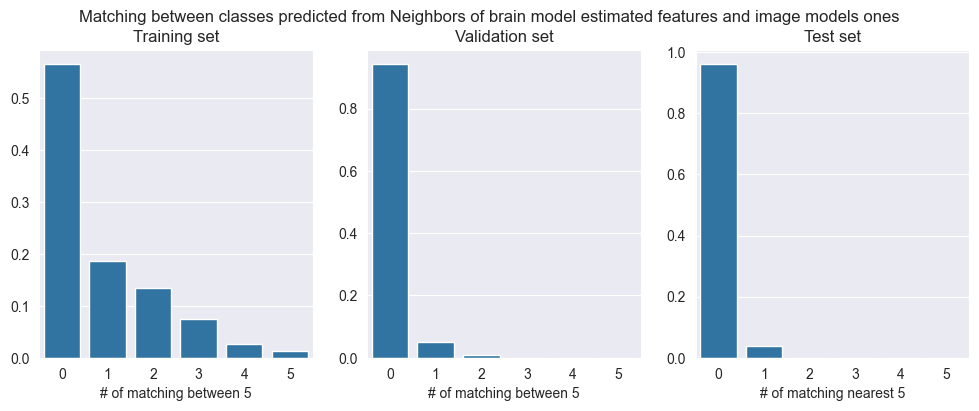

In [49]:
fig,axs=plt.subplots(1,3,figsize=(12,4))

fig.suptitle("Matching between classes predicted from Neighbors of brain model estimated features and image models ones")

sns.barplot(x=list(acc_nbrs_train.keys()),y=list(acc_nbrs_train.values()),ax=axs[0],color="tab:blue")
axs[0].set_title("Training set")
axs[0].set_xlabel("# of matching between 5")

sns.barplot(x=list(acc_nbrs_val.keys()),y=list(acc_nbrs_val.values()),ax=axs[1],color="tab:blue")
axs[1].set_title("Validation set")
axs[1].set_xlabel("# of matching between 5")

sns.barplot(x=list(acc_nbrs_test.keys()),y=list(acc_nbrs_test.values()),ax=axs[2],color="tab:blue")
axs[2].set_title("Test set")
axs[2].set_xlabel("# of matching nearest 5")


# generation